# A first example: sampling the dual-moon distribution

In this tutorial we will showcase the ability of ``flowMC`` to sample efficiently a 5-dimensional multi-modal distribution. We will go through the typical steps of verification one follows to confirm the quality of the samples at the end of the MCMC run. 

First we import the necessary modules:

In [1]:
import numpy as np
import jax
import jax.numpy as jnp  
from jax.scipy.stats import norm

First, we define the target distribution using ``jax.numpy``. The Neal Funnel is famous benchmark due to this complicated geometry: the marginal of the first coordinate as a variance scaling like an exponential of itself.  

In [3]:
n_dim = 5

def target_neal_funnel(x):
    """
    Log-posterior
    """
    y_pdf = norm.logpdf(x[0], loc=0, scale=3)
    x_pdf = norm.logpdf(x[1:], loc=0, scale=jnp.exp(x[0] / 2))
    return y_pdf + jnp.sum(x_pdf)



Then choose the number of chains, their initial positions, the local sampler, the normalizing flow model and initialize the sampler.

In [34]:
from flowMC.utils.PRNG_keys import initialize_rng_keys
from flowMC.nfmodel.rqSpline import RQSpline
from flowMC.sampler.MALA import make_mala_sampler
from flowMC.sampler.Sampler import Sampler

n_chains = 20
rng_key_set = initialize_rng_keys(n_chains, seed=42)
initial_position = jax.random.normal(rng_key_set[0], shape=(n_chains, n_dim))

n_layer = 5
n_hidden = 64
model = RQSpline(n_dim, n_layer, [n_hidden, n_hidden], 8)

local_sampler_caller = lambda x: make_mala_sampler(x, jit=True)

# global-local-training-schedule
n_loop_training = 20
n_loop_production = 50
n_local_steps = 150
n_global_steps = 50

local_sampler_params = {'dt': 1e-1}

# training arguments
num_epochs = 5
learning_rate = 0.005
momentum = 0.9
batch_size = 5000
max_samples = 5000

nf_sampler = Sampler(
    n_dim,
    rng_key_set,
    local_sampler_caller,
    local_sampler_params,
    target_neal_funnel,
    model,
    n_loop_training=n_loop_training,
    n_loop_production=n_loop_production,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    batch_size=batch_size,
    use_global=True
)

Let's launch the sampler. Note that the first cycle of sampling-training is the slowest because of the just-in time compilation happening under the hood.

In [35]:
nf_sampler.sample(initial_position)

No autotune found, use input sampler_params
Training normalizing flow


Training NF: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Starting Production run


Sampling Locally: 100%|██████████| 149/149 [00:00<00:00, 511.90it/s]


We can now plot the results, first looking at the outcome of training loops and then sample collected during the production loops.

Logged during tuning: dict_keys(['chains', 'log_prob', 'local_accs', 'global_accs', 'loss_vals'])


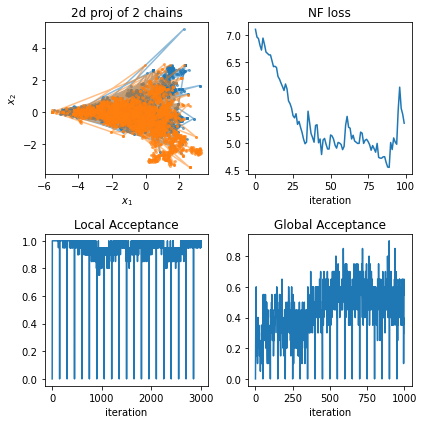

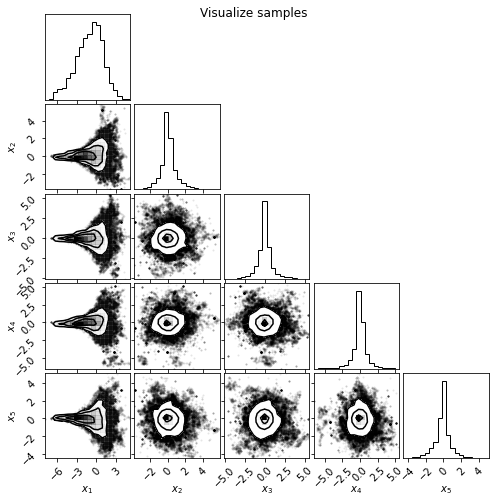

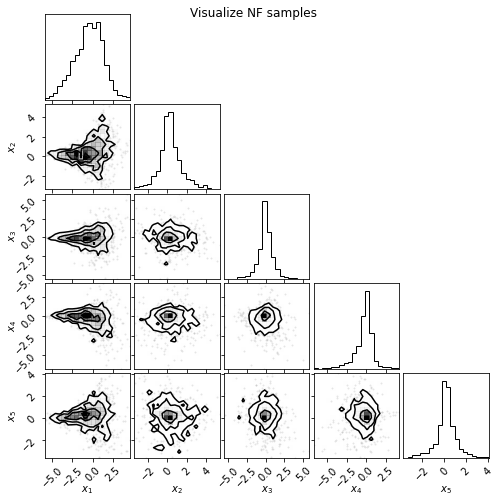

In [36]:
import corner
import matplotlib.pyplot as plt

out_train = nf_sampler.get_sampler_state(training=True)
print('Logged during tuning:', out_train.keys())

chains = np.array(out_train['chains'])
global_accs = np.array(out_train['global_accs'])
local_accs = np.array(out_train['local_accs'])
loss_vals = np.array(out_train['loss_vals'])
nf_samples = np.array(nf_sampler.sample_flow(1000)[1])


# Plot 2 chains in the plane of 2 coordinates for first visual check 
plt.figure(figsize=(6, 6))
axs = [plt.subplot(2, 2, i + 1) for i in range(4)]
plt.sca(axs[0])
plt.title("2d proj of 2 chains")

plt.plot(chains[0, :, 0], chains[0, :, 1], 'o-', alpha=0.5, ms=2)
plt.plot(chains[1, :, 0], chains[1, :, 1], 'o-', alpha=0.5, ms=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("NF loss")
plt.plot(loss_vals.reshape(-1))
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[3])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")
plt.tight_layout()
plt.show(block=False)

labels=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]
# Plot all chains
figure = corner.corner(
    chains.reshape(-1, n_dim), labels=labels
)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")
plt.show(block=False)

# Plot Nf samples
figure = corner.corner(nf_samples, labels=labels)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize NF samples")
plt.show()


Second, let's analyze the production run. We will first visualize the samples and acceptance of the local and global sampler. 

Logged in production: dict_keys(['chains', 'log_prob', 'local_accs', 'global_accs'])


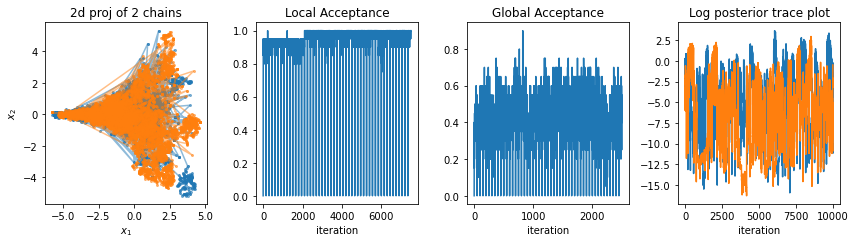

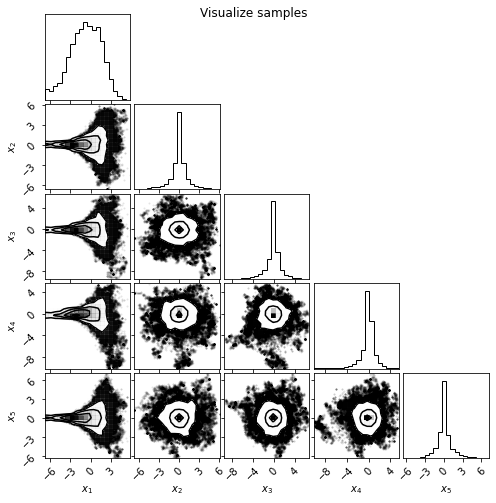

In [37]:
out_prod = nf_sampler.get_sampler_state() 
print('Logged in production:', out_prod.keys())

chains = np.array(out_prod['chains'])
index = 1 # choosing random chain index to plot results
global_accs = np.array(out_prod['global_accs'])
local_accs = np.array(out_prod['local_accs'])
log_prob_trace = np.array(out_prod['log_prob'][np.array([index,index+10]),:]).T

plt.figure(figsize=(12, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
plt.sca(axs[0])
plt.title("2d proj of 2 chains")

plt.plot(chains[index, :, 0], chains[index, :, 1], 'o-', alpha=0.5, ms=2)
plt.plot(chains[index+10, :, 0], chains[index+10, :, 1], 'o-', alpha=0.5, ms=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[3])
plt.title("Log posterior trace plot")
plt.plot(log_prob_trace)
plt.xlabel("iteration")

plt.tight_layout()
plt.show(block=False)

labels=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]
# Plot all chains
figure = corner.corner(
    chains.reshape(-1, n_dim), labels=labels
)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")
plt.show(block=False)



Next, we use the `arviz` package to compute $\hat R$ and the Effective Sample Size (ESS) as a function of the length of the chain.

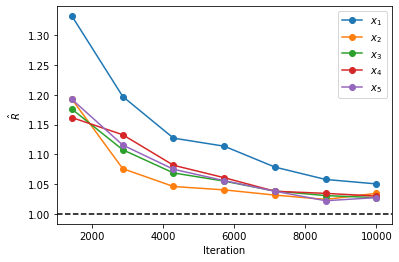

In [38]:
import arviz as az
from arviz.utils import get_coords, _var_names

## Load data as arviz InferenceData class
idata = az.convert_to_inference_data(chains)
coords = {}
data = get_coords(az.convert_to_dataset(idata, group="posterior"), coords)
var_names = None
filter_vars = None
var_names = _var_names(var_names, data, filter_vars)
n_draws = data.dims["draw"]
n_samples = n_draws * data.dims["chain"]
first_draw = data.draw.values[0] # int of where where things should start

## Compute where to split the data to diagnostic the convergence
n_split = 7
xdata = np.linspace(n_samples / n_split, n_samples, n_split)
draw_divisions = np.linspace(n_draws // n_split, n_draws, n_split, dtype=int)


rhat_s = np.stack([np.array(az.rhat(data.sel(draw=slice(first_draw + draw_div)),
                    var_names=var_names,
                    method="rank",
                )['x'])
        for draw_div in draw_divisions
        ])

plt.figure()
plt.plot(draw_divisions, rhat_s, '-o',  label=labels)
plt.axhline(1, c='k', ls='--')
plt.xlabel('Iteration')
plt.ylabel(r'$\hat{R}$')
plt.legend()